In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import time
import emcee
import warnings

warnings.filterwarnings("ignore")

starry.config.quiet = True
np.random.seed(1)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import psutil
num_cpus = psutil.cpu_count(logical=False)

In [3]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [4]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    med_flux = np.median(flux)
    flux /= med_flux
    err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux

(721, 256)


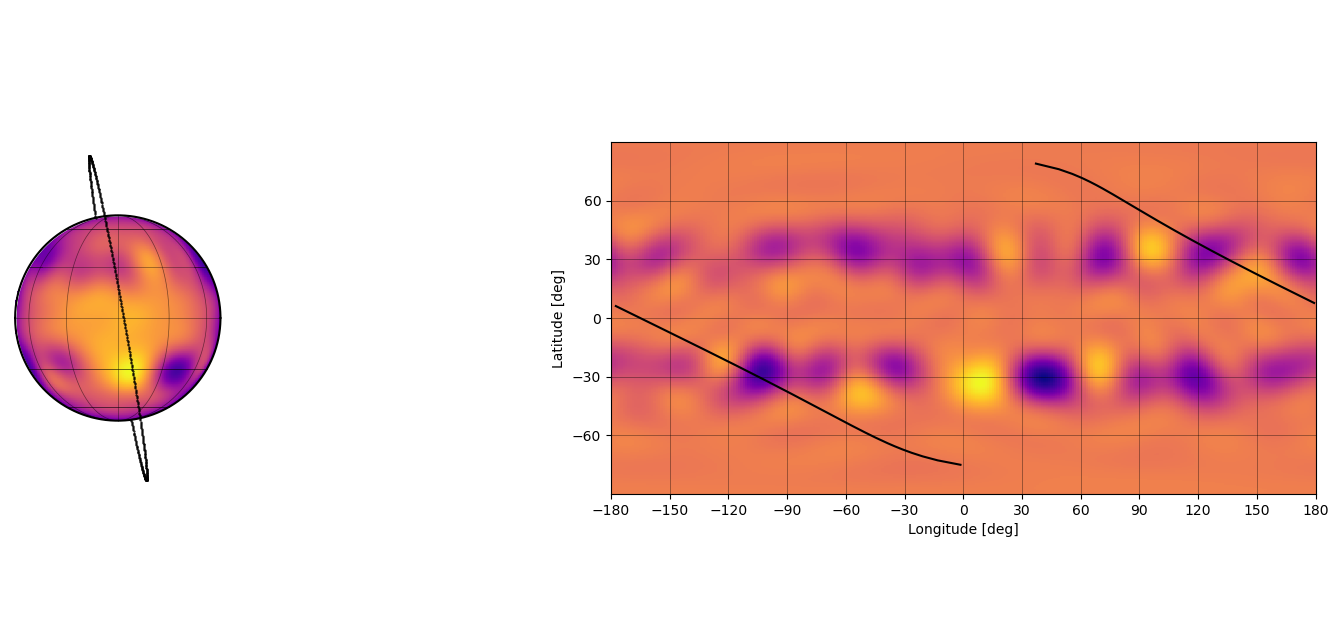

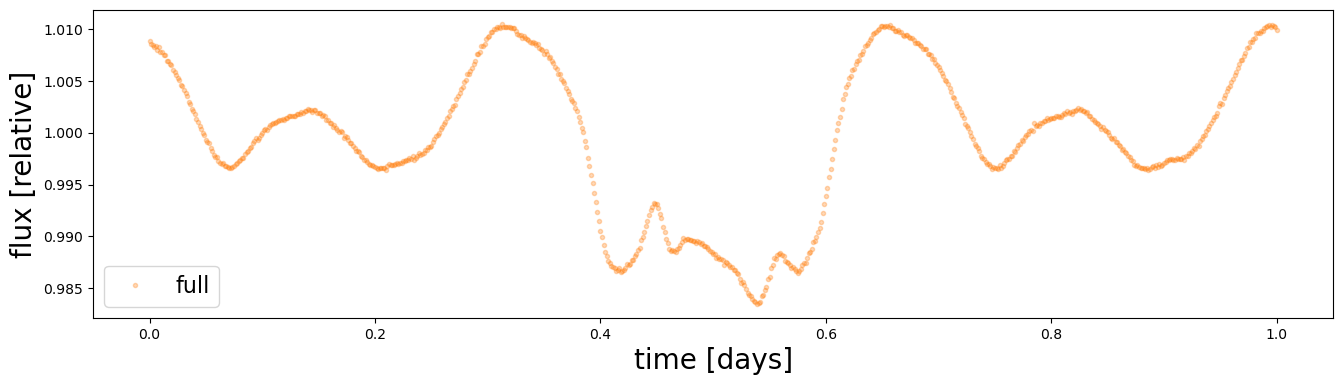

In [5]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Angle},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux = generate(t, params, error=1e-4)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=0.3, label="full")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

# pm.MvNormal()

In [20]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    theta = (360 * t / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")
    
    # Compute the flux covariance
    cov_ylm = sp.cov_ylm
    cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
    cov_flux += tt.diag(err) ** 2
    # print(cov_flux.eval().shape)

    # Compute the flux mean; remember to offset Y_{0,0} by one
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) / norm

    # Marginal likelihood
    pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux)

the shape of the covariance matrix is (721, 721)

In [21]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [22]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 2720.517763001451 -> 5447.710857205615
100%|██████████| 1/1 [00:00<00:00, 22.77it/s]

[10.52242751  0.08692389 18.92596687 28.55539854  3.76305598  0.95013746]


In [23]:
mci.logp(x)

array(5447.7108572)

In [25]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [03:41<00:00,  2.21s/it]

Serial took 223.7 seconds


# The Woodbury Identity

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [26]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    theta = (360 * t / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        # sigma=sigma,
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")

    A /= norm
    
    Sigma_s = sp.cov_ylm 
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) 
    K = len(t)


    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))
    # print(U.shape.eval())

    log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 

    r = tt.as_tensor_variable(flux) - mu_flux
    v = tt.dot(A.T,(r/tt.square(err)))
    Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
    # print(Q.eval())

    loglike = -0.5 * Q
    loglike -= 0.5 * log_sigmadet
    loglike -= 0.5 * K * tt.log(2 * np.pi)

    # print(loglike.eval())

    pm.Potential("lnlike", loglike)

The shape of U matrix is (256,256)

In [27]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [28]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 2720.517763013156 -> 5447.710768994829


100%|██████████| 1/1 [00:00<00:00, 23.30it/s]

[10.51710748  0.08690554 18.93625414 28.56454583  3.76944388  0.95016741]


In [29]:
mci.logp(x)

array(5447.710769)

In [30]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("The Woodbury Identity took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [04:41<00:00,  2.81s/it]

The Woodbury Identity took 284.0 seconds


# Cholesky

In [31]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    theta = (360 * t / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")
    
    # Compute the flux covariance
    cov_ylm = sp.cov_ylm
    Sigma = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
    Sigma += tt.diag(err) ** 2
    # print(cov_flux.eval().shape)

    # Compute the flux mean; remember to offset Y_{0,0} by one
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)

    # Marginal likelihood
    K = len(t)

    cho_gp_cov = cho_factor(Sigma)

    mu_flux = tt.reshape(tt.dot(A, mu_ylm) / norm, (K, 1))
    r = (
        tt.reshape(tt.transpose(tt.as_tensor_variable(flux)), (K, -1))
        - mu_flux
    )
    M = r.shape[1]
    lnlikemod = -0.5 * tt.sum(
            tt.batched_dot(
                tt.transpose(r), tt.transpose(cho_solve(cho_gp_cov, r))
            )
        )
    lnlikemod -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
    lnlikemod -= 0.5 * K * M * tt.log(2 * np.pi)

    pm.Potential("lnlike", lnlikemod)

In [32]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [33]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 2720.51776300145 -> 5447.712381941099


100%|██████████| 1/1 [00:00<00:00, 23.00it/s]

[10.52619351  0.08703833 18.88631189 28.56344962  3.7570345   0.95013636]


In [34]:
mci.logp(x)

array(5447.70903821)

In [35]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Cholesky took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [03:41<00:00,  2.22s/it]

Cholesky took 224.0 seconds


# The Woodbury Identity + Binned light curve

In [13]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

In [37]:
# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

In [38]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t_)

    # Get the flux design matrix
    theta = (360 * t_ / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        # sigma=sigma,
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")

    A /= (norm*np.sqrt(10)) # due to binning
    
    Sigma_s = sp.cov_ylm 
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) 
    K = len(t)


    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err_[:,None])))
    # print(U.shape.eval())

    log_sigmadet = 2*tt.sum(tt.log(err_)) + pmm.logdet(U) 

    r = tt.as_tensor_variable(flux_) - mu_flux
    v = tt.dot(A.T,(r/tt.square(err_)))
    Q = tt.sum(tt.square(r/err_)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
    # print(Q.eval())

    loglike = -0.5 * Q
    loglike -= 0.5 * log_sigmadet
    loglike -= 0.5 * K * tt.log(2 * np.pi)

    # print(loglike.eval())

    pm.Potential("lnlike", loglike)

In [39]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [40]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: -1405.1136199840205 -> 1722.411897273216


100%|██████████| 1/1 [00:00<00:00, 23.28it/s]

[ 6.5349734   0.22868933 19.6966042  36.77724447  9.32693987  0.94732253]


In [41]:
mci.logp(x)

array(1722.4121619)

In [42]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("The binned light curve took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [04:48<00:00,  2.88s/it]

The binned light curve took 291.0 seconds


# Let's cretate a longer light curve

(7201, 256)


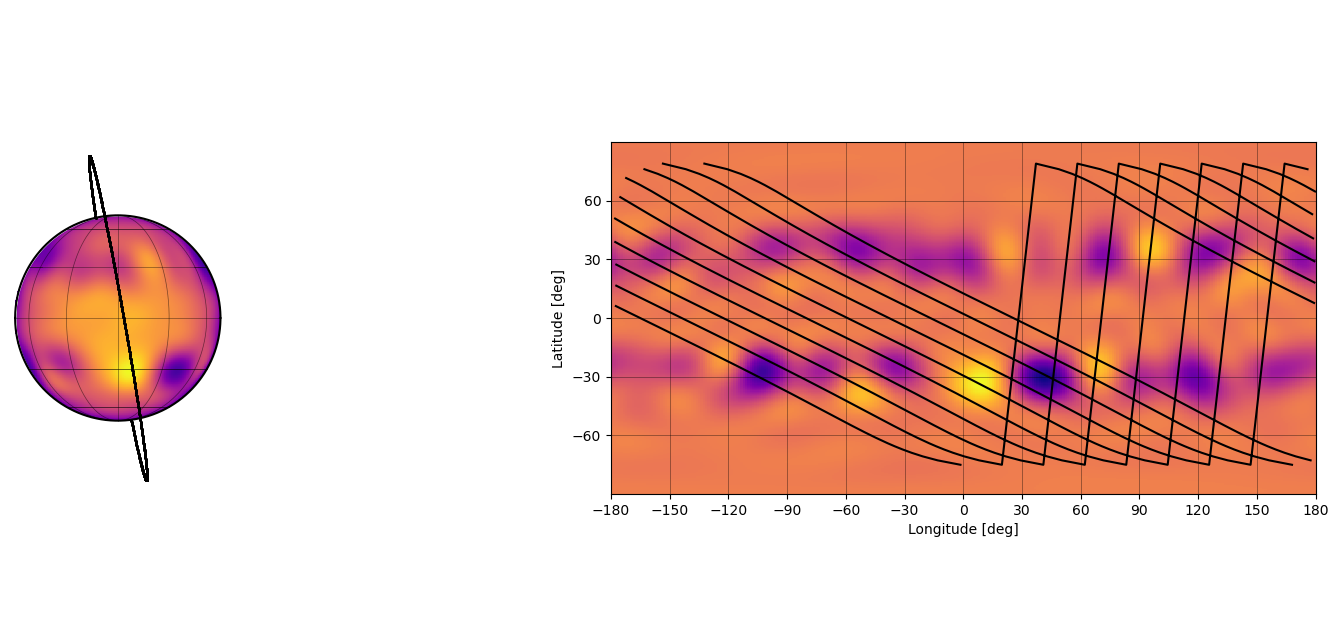

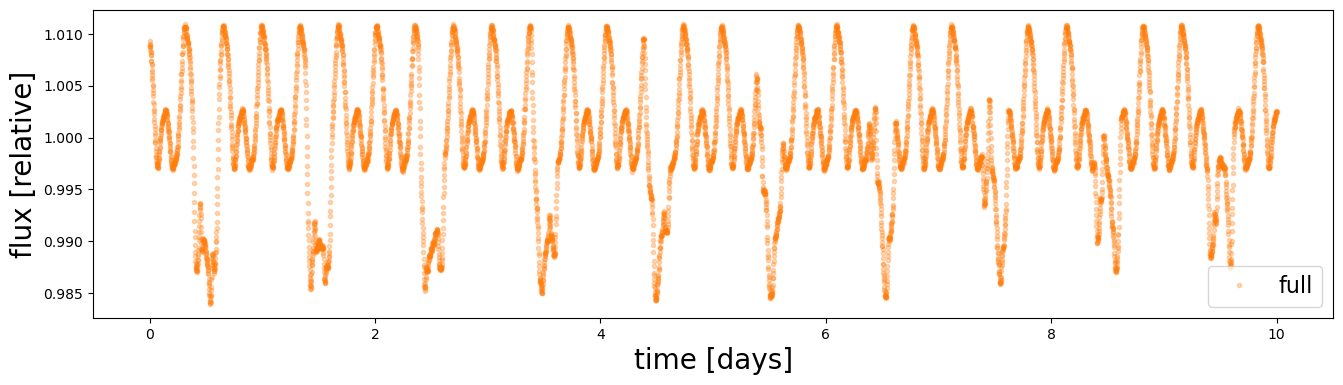

In [6]:
# *** Time array (10 day @ 2 min cadence)
t = np.arange(0, 10, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux = generate(t, params, error=1e-4)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=0.3, label="full")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

## pm.MvNormal()

In [64]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    theta = (360 * t / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")
    
    # Compute the flux covariance
    cov_ylm = sp.cov_ylm
    cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
    cov_flux += tt.diag(err) ** 2
    # print(cov_flux.eval().shape)

    # Compute the flux mean; remember to offset Y_{0,0} by one
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) / norm

    # Marginal likelihood
    pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux)

In [65]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [66]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 38812.50213980158 -> 55317.75506971825


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

[10.0230997   0.0681192  29.27421216 30.19699565  5.00072447  0.9462608 ]


In [67]:
mci.logp(x)

array(55317.74806693)

In [68]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("MvNormal took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [1:09:57<00:00, 41.97s/it]

MvNormal took 4239.3 seconds


# The Woodbury Identity

In [7]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    theta = (360 * t / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        # sigma=sigma,
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")

    A /= norm
    
    Sigma_s = sp.cov_ylm 
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) 
    K = len(t)


    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))
    # print(U.shape.eval())

    log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 

    r = tt.as_tensor_variable(flux) - mu_flux
    v = tt.dot(A.T,(r/tt.square(err)))
    Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
    # print(Q.eval())

    loglike = -0.5 * Q
    loglike -= 0.5 * log_sigmadet
    loglike -= 0.5 * K * tt.log(2 * np.pi)

    # print(loglike.eval())

    pm.Potential("lnlike", loglike)

In [8]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [9]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 38812.502173027846 -> 55318.53328284809


100%|██████████| 1/1 [00:00<00:00, 16.26it/s]

[10.03204486  0.0697543  28.50992305 30.23738143  4.97746193  0.94629576]


In [10]:
mci.logp(x)

array(55318.53328283)

In [11]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("the woodbury identity took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [02:29<00:00,  1.50s/it]

the woodbury identity took 151.3 seconds


In [21]:
import ray
ray.init(num_cpus=num_cpus)

2022-12-07 16:34:32,287	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.8.13
Ray version:,2.1.0


In [30]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)

start = time.time()
steps = np.linspace(1,nsteps)

def my_function(init=p0, nsteps=nsteps):
    return sampler.run_mcmc(init, nsteps, progress=True)


start = time.time()
ray.wait(my_function())
end = time.time()
serial_time = end - start
print("the woodbury identity with ray took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


TypeError: wait() expected a list of ray.ObjectRef, got <class 'emcee.state.State'>

## multiprocessing

In [12]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp, pool=pool)
    start = time.time()
    pool.map(sampler.run_mcmc(p0, nsteps, progress=True))
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.

## binned

In [14]:
# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

In [15]:
t_.shape

(3011,)

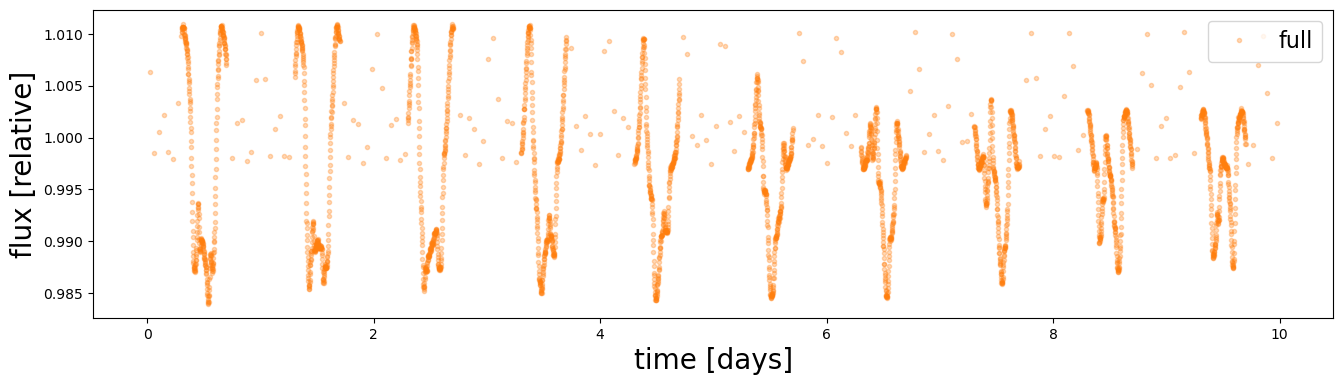

In [16]:
# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t_, flux_, "C1.", alpha=0.3, label="full")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [17]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]

# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]


starry.config.lazy = True

with pm.Model() as model:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = parameter("star.u1")
    map[2] = parameter("star.u2")
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t_)

    # Get the flux design matrix
    theta = (360 * t_ / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        # sigma=sigma,
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")

    A /= (norm*np.sqrt(30))
    
    Sigma_s = sp.cov_ylm 
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) 
    K = len(t_)


    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err_[:,None])))
    # print(U.shape.eval())

    log_sigmadet = 2*tt.sum(tt.log(err_)) + pmm.logdet(U) 

    r = tt.as_tensor_variable(flux_) - mu_flux
    v = tt.dot(A.T,(r/tt.square(err_)))
    Q = tt.sum(tt.square(r/err_)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
    # print(Q.eval())

    loglike = -0.5 * Q
    loglike -= 0.5 * log_sigmadet
    loglike -= 0.5 * K * tt.log(2 * np.pi)

    # print(loglike.eval())

    pm.Potential("lnlike", loglike)

In [18]:
with model:
    mci = MCMCInterface()

In [19]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: -58465326.55878291 -> -1124414.5050890418


100%|██████████| 1/1 [00:00<00:00, 23.63it/s]

[1.81854726e+01 4.99996352e-01 2.98952651e+01 5.53000313e-11
 9.96818641e+00 8.00619092e-01]


In [20]:
mci.logp(x)

array(-1124414.50142685)

In [21]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)
# Number of parameters
ndim = p0.shape[1]

# Run the chains
np.random.seed(0)
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("the woodbury identity with binned light curve took {0:.1f} seconds".format(serial_time))
sampler.reset()

100%|██████████| 100/100 [01:58<00:00,  1.18s/it]

the woodbury identity with binned light curve took 119.7 seconds
